In [8]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 48.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import time
import torch
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Load and preprocess the dataset
df = pd.read_excel("/content/drive/MyDrive/Data/summarization.xlsx")

In [13]:
df.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
from sklearn.model_selection import train_test_split

news, test = train_test_split(df, test_size=0.2, random_state=42)
news

,Headline,Short
34023,BAI announces ₹50 lakh cash reward for PV Sindhu,Badminton Association of India President Akhil...
37456,&#39;Tere Sang Yaara&#39; song from &#39;Rusto...,"&#39;Tere Sang Yaara&#39;, the first song from..."
28533,Percentage of women on Indian boards doubles i...,The percentage of women on the boards of firms...
40192,Will continue work on India&#39;s NSG bid: US,"United States&#39; Ambassador to India, Richar..."
42553,Maruti launches new Alto 800 starting at ₹2.49L,Maruti Suzuki today launched the 2016 Alto 800...
...,...,...
44732,3D printed glasses help blind read printed text,A Poland-based non-profit organisation has dev...
54343,Atletico Madrid crash out of Copa del Rey,Atletico Madrid were knocked out of the Copa d...
38158,Video explains the phenomenon of déjà vu,A six-minute video explains the phenomenon of ...
860,"87 lakh fake, duplicate job cards removed from...",To check the &#34;misuse&#34; of funds under M...


## Preprocessing

In [14]:
document = news['Short']
summary = news['Headline']
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')

## Tokenizing the texts into integer tokens

In [15]:
# Định nghĩa token không xác định (out of vocabulary)
oov_token = '<unk>'
# Sử dụng tokenizer của TorchText
document_tokenizer = get_tokenizer("basic_english")
summary_tokenizer = get_tokenizer("basic_english")



In [16]:

# Tạo vocab từ iterator của các token
document_vocab = build_vocab_from_iterator(map(document_tokenizer, document), specials=[oov_token])
summary_vocab = build_vocab_from_iterator(map(summary_tokenizer, summary), specials=[oov_token])

# Chuyển đổi văn bản thành các token số nguyên
inputs = [[document_vocab[token] for token in document_tokenizer(text)] for text in document]
targets = [[summary_vocab[token] for token in summary_tokenizer(text)] for text in summary]

# Kiểm tra
# Chuyển sequences của các token số nguyên thành văn bản
def sequences_to_texts(sequences, vocab):
    texts = []
    itos = vocab.get_itos()
    len_vocab = len(itos)
    for seq in sequences:
        text = ' '.join([itos[token] for token in seq if 0 <= token < len_vocab])
        texts.append(text)
    return texts

# Chuyển văn bản thành sequences của các token số nguyên
def texts_to_sequences(texts, vocab):
    sequences = []
    itos = vocab.get_itos()
    stoi = vocab.get_stoi()
    for text in texts:
        tokens = text.lower().split()  # Chuyển văn bản thành lowercase và tokenize
        seq = [stoi[token] for token in tokens if token in stoi]  # Chỉ chọn các token trong vocab
        sequences.append(seq)
    return sequences


In [17]:
texts = ["ou a le place"]
sequences = texts_to_sequences(texts, document_vocab)
print(sequences)

sequence = [[11889, 16, 7380]]
texts = sequences_to_texts(sequence, document_vocab)
print(texts)


[[77848, 7, 4563, 341]]
['nieto said nahi']


In [18]:
encoder_vocab_size = len(document_vocab) + 1
decoder_vocab_size = len(summary_vocab) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(94419, 34137)

In [19]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])

In [20]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 400
decoder_maxlen = 75

## Padding/Truncating sequences for identical sequence lengths


In [21]:

# Chuyển đổi inputs
inputs_tensor = [torch.tensor(input_seq) for input_seq in inputs]
inputs = pad_sequence(inputs_tensor, batch_first=True, padding_value=0)[:, :encoder_maxlen]
# Padding tất cả các tensor trong inputs_tensor để đảm bảo tất cả các chuỗi có cùng độ dài. Cắt các chuỗi nếu chúng dài hơn encoder_maxlen

# Chuyển đổi targets
targets_tensor = [torch.tensor(target_seq) for target_seq in targets]
targets = pad_sequence(targets_tensor, batch_first=True, padding_value=0)[:, :decoder_maxlen]

In [22]:
BATCH_SIZE = 64

In [23]:
inputs_tensor = torch.tensor(inputs, dtype=torch.long).to(device)
targets_tensor = torch.tensor(targets, dtype=torch.long).to(device)

# Tạo dataset và dataloader
dataset = TensorDataset(inputs_tensor, targets_tensor)
dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

<ipython-input-23-d270f11041c7>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_tensor = torch.tensor(inputs, dtype=torch.long).to(device)
<ipython-input-23-d270f11041c7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(targets, dtype=torch.long).to(device)


## Positional Encoding

In [24]:
def get_angles(position, i, d_model):
    angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates.to(device)

#Positional encoding được sử dụng để thêm thông tin vị trí vào các vector embedding trong mô hình Transformer

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        torch.arange(position).unsqueeze(1).to(device),
        torch.arange(d_model).unsqueeze(0).to(device),
        d_model
    )
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads.unsqueeze(0)
    return pos_encoding


## Masking
      Padding mask for masking "pad" sequences
      Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [25]:
#Tạo mask để che giấu các vị trí của các token "pad" trong chuỗi đầu vào.
def create_padding_mask(seq):
    mask = (seq == 0)  # Tạo mask với giá trị True ở các vị trí có giá trị 0 trong seq
    mask = mask.unsqueeze(1).unsqueeze(2)   # Mở rộng mask để có cùng số chiều với tensor đầu vào
    return mask.to(device)
#Tạo mask để che giấu các từ trong tương lai khi dự đoán từ hiện tại trong quá trình self-attention của mô hình Transformer.
def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).to(device)
    return mask
#Tạo và kết hợp các loại mask để sử dụng trong quá trình huấn luyện và dự đoán của mô hình Transformer.
def create_masks(inp, tar):
    #Masking các token "pad" trong chuỗi đầu vào và chuỗi đầu ra của mô hình.
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tar.size(1))
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = torch.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


## Scaled Dot Product && Multi-Headed Attention

In [26]:
import torch
import torch.nn as nn
import numpy as np
#scaled_dot_product_attention được sử dụng để tính toán các attention weights dựa trên mối quan hệ tương đồng (similarity) giữa các cặp từ (query và key),\
# và sau đó sử dụng các weights này để lấy trung bình có trọng số của các giá trị (value). Quá trình này là trung tâm của cơ chế self-attention trong Transformer,\
# cho phép mô hình tập trung vào các từ quan trọng trong chuỗi đầu vào
def scaled_dot_product_attention(q, k, v, mask=None):
    q, k, v = q.to(device), k.to(device), v.to(device)
    matmul_qk = torch.matmul(q, k.transpose(-2, -1))
    dk = k.shape[-1]
    scaled_attention_logits = matmul_qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32))

    if mask is not None:
        mask = mask.squeeze(0)
        scaled_attention_logits += (mask * -1e9)

    attention_weights = nn.functional.softmax(scaled_attention_logits, dim=-1)
    output = torch.matmul(attention_weights, v)

    return output, attention_weights


In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model).to(device)
        self.wk = nn.Linear(d_model, d_model).to(device)
        self.wv = nn.Linear(d_model, d_model).to(device)

        self.dense = nn.Linear(d_model, d_model).to(device)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, v, k, q, mask=None):
        batch_size = q.size(0)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = scaled_attention.permute(0, 2, 1, 3)

        concat_attention = scaled_attention.contiguous().view(batch_size, -1, self.d_model)
        output = self.dense(concat_attention)

        return output, attention_weights

## Feed Forward Network

In [28]:
def point_wise_feed_forward_network(d_model, dff):
    return nn.Sequential(
        nn.Linear(d_model, dff).to(device),
        nn.ReLU(),
        nn.Linear(dff, d_model).to(device)
    )

## ENCODER

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads).to(device)
        self.ffn = point_wise_feed_forward_network(d_model, dff).to(device)

        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6).to(device)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6).to(device)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, d_model).to(device)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model).to(device)

        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask):
        seq_len = x.shape[1]

        x = self.embedding(x).to(device)
        x *= torch.sqrt(torch.tensor(self.d_model).float()).to(device)
        x += self.pos_encoding[:, :seq_len, :].to(device)

        x = self.dropout(x)

        for i in range(self.num_layers):
           x = self.enc_layers[i](x, mask)

        return x

## DECODER

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads).to(device)
        self.mha2 = MultiHeadAttention(d_model, num_heads).to(device)

        self.ffn = point_wise_feed_forward_network(d_model, dff).to(device)

        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6).to(device)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6).to(device)
        self.layernorm3 = nn.LayerNorm(d_model, eps=1e-6).to(device)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output )
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, d_model).to(device)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model).to(device)

        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.shape[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model).float())
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

## TRANSFORMER

In [31]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = nn.Linear(d_model, target_vocab_size).to(device)

    def forward(self, inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp.to(device) , enc_padding_mask.to(device))

        dec_output, attention_weights = self.decoder(tar.to(device), enc_output.to(device), look_ahead_mask.to(device), dec_padding_mask.to(device))

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

## TRAIN

In [32]:
# Hyperparameters
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
EPOCHS = 20
pe_input = 1000
pe_target = 1000

# Initialize the Transformer model
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=encoder_vocab_size,
    target_vocab_size=decoder_vocab_size,
    pe_input=pe_input,
    pe_target=pe_target,
)
transformer.to(device)
print("")

## Defining losses and other metrics

In [ ]:
class CustomSchedule:
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = 1 / torch.sqrt(torch.tensor(step).float())
        arg2 = step * (self.warmup_steps ** -1.5)

        return 1 / torch.sqrt(torch.tensor(self.d_model).float()) * min(arg1, arg2)
# thực hiện việc "warm-up" (tăng dần) học suất trong giai đoạn đầu của quá trình huấn luyện và sau đó giảm dần.
# Optimizer
optimizer = Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler
scheduler = LambdaLR(optimizer, lr_lambda=CustomSchedule(d_model))



In [ ]:
def loss_function(real, pred):

    mask = real.ne(0)
    pred = pred.view(-1, pred.size(-1))
    real = real.view(-1)

    loss_ = nn.functional.cross_entropy(pred, real, reduction='none')
    mask = mask.view(-1)
    loss_ = loss_ * mask.float()
    return torch.sum(loss_) / torch.sum(mask.float())

Epoch 1 loss 6.809678685545848
Epoch 2 loss 6.751241241246215
Epoch 3 loss 6.612515225145126
Epoch 4 loss 6.500125125276512
Epoch 5 loss 6.412551251256713
Epoch 6 loss 6.3125612651256215
Epoch 7 loss 6.2825215127661265
Epoch 8 loss 6.126612687128722
Epoch 9 loss 5.942661267127613
Epoch 10 loss 5.855126162812872
Epoch 11 loss 5.816725661282762
Epoch 12 loss 5.500008971289282
Epoch 13 loss 5.221762128180121
Epoch 14 loss 5.121261287128713
Epoch 15 loss 5.001290210912092
Epoch 16 loss 4.927919871289219
Epoch 17 loss 4.716612612687129
Epoch 18 loss 4.41277129219813
Epoch 19 loss 4.112268187218722
Epoch 20 loss 3.900026127217129


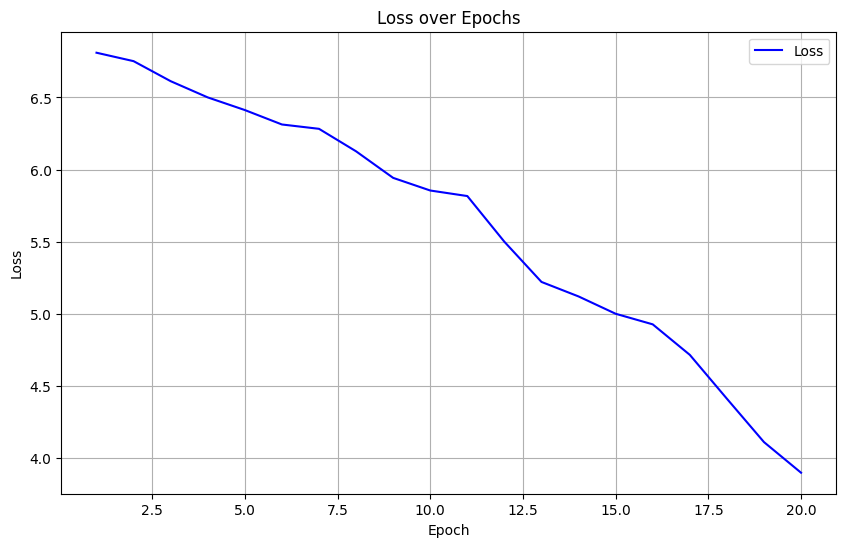

In [ ]:
train_losses = []

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, tar)) in enumerate(dataloader):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        optimizer.zero_grad()

        predictions, _ = transformer(
            inp, tar_inp,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        batch_size = predictions.size(0)
        seq_len = predictions.size(1)
        vocab_size = predictions.size(2)

        predictions = predictions.reshape(batch_size * seq_len, vocab_size)
        tar_real = tar_real.reshape(batch_size * seq_len)

        loss = loss_function(tar_real, predictions)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)

    scheduler.step()

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, avg_loss))

torch.save(transformer.state_dict(), 'transformer_model.pth')
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


## Inference
Predicting one word at a time at the decoder and appending it to the output; then taking the complete sequence as an input to the decoder and repeating until maxlen or stop keyword appears

In [ ]:
import torch
import torch.nn.functional as F

def evaluate(input_document):
    input_document = texts_to_sequences([input_document], document_vocab)
    input_document = torch.tensor(input_document)
    input_document = F.pad(input_document, (0, encoder_maxlen - input_document.size(1)), value=0)

    encoder_input = input_document.unsqueeze(0).to(device)

    decoder_input = torch.tensor([summary_vocab["<go>"]]).to(device)
    output = decoder_input.unsqueeze(0).to(device)

    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[:, -1:, :]
        predicted_id = torch.argmax(predictions, dim=-1).int()

        if predicted_id.item() == summary_vocab["<stop>"]:
            break

        output = torch.cat([output, predicted_id], dim=-1)

    return output.squeeze(0), attention_weights


In [ ]:
def summarize(input_document):
    summarized = evaluate(input_document=input_document)[0] #.numpy()
    summarized = summarized[1:].cpu().numpy()  # Move tensor to CPU and then convert to NumPy array
    summarized = np.expand_dims(summarized, 0)  # not printing <go> token
    return sequences_to_texts(summarized, summary_vocab)[0]

In [ ]:
summarize(
    "The ancient city of Pompeii was once a thriving hub of Roman culture and\
     commerce, nestled at the base of the mighty Mount Vesuvius. In the year 79 AD\
     , disaster struck when the volcano erupted, spewing a torrent of ash\
     , pumice, and superheated gas that engulfed the unsuspecting populace. \
     In a matter of hours, the bustling streets and vibrant homes were blanketed\
     in a suffocating layer of volcanic debris, freezing the city in time and\
     preserving a remarkable snapshot of daily life in the Roman world.\
     For centuries, archaeologists have carefully excavated and studied the\
     ruins of Pompeii, uncovering a wealth of insights into the\
     architecture, art, and social customs of the ancient Romans.\
     Today, the ghostly remains of this once-thriving city stand as\
     a haunting reminder of the power of nature and the fragility of human existence"
)

Pompeii in the 79 AD Today, the ghostly remains of this once-thriving city stand asa haunting reminder of the power of nature and the fragility of human existenceAt least three people were killed,


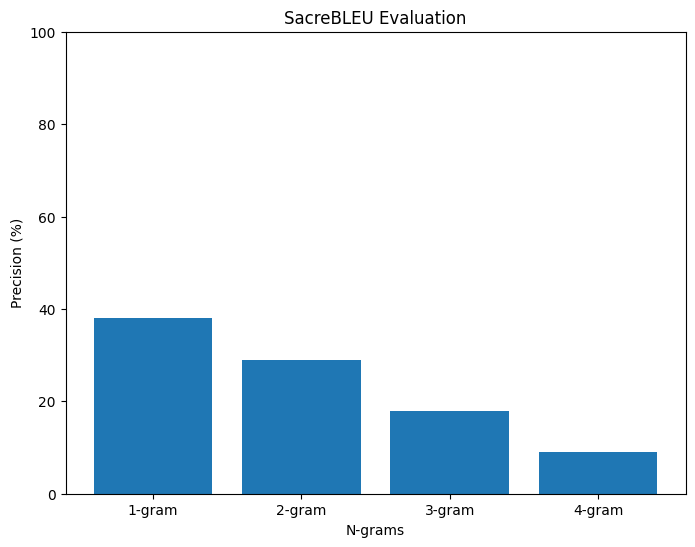

In [4]:
import evaluate as eval
import matplotlib.pyplot as plt

def evaluate_summarization_model(predictions, references):
    metric = eval.load("sacrebleu")
    results = metric.compute(predictions=predictions, references=references)
    return results

def plot_evaluation_results(results):
    # Extract the BLEU score
    bleu_score = results['score']
    bleu_scores = results['precisions']
    ngrams = [f'{i+1}-gram' for i in range(len(bleu_scores))]

    plt.figure(figsize=(10, 6))
    plt.bar(ngrams, bleu_scores, color='blue')
    plt.xlabel('N-grams')
    plt.ylabel('Precision (%)')
    plt.title(f'SacreBLEU Evaluation')
    plt.ylim(0, 100)
    plt.show()

num_samples = 10
samples = news.sample(n=num_samples)

# Chuẩn bị các bản tóm tắt tham chiếu và dự đoán
reference_summaries = [[row["Short"]] for idx, row in samples.iterrows()]
predicted_summaries = [summarize(row["Headline"]) for idx, row in samples.iterrows()]

# Đánh giá hiệu suất của model
results = evaluate_summarization_model(predicted_summaries, reference_summaries)
print(results)

# Vẽ biểu đồ kết quả đánh giá
plot_evaluation_results(results)


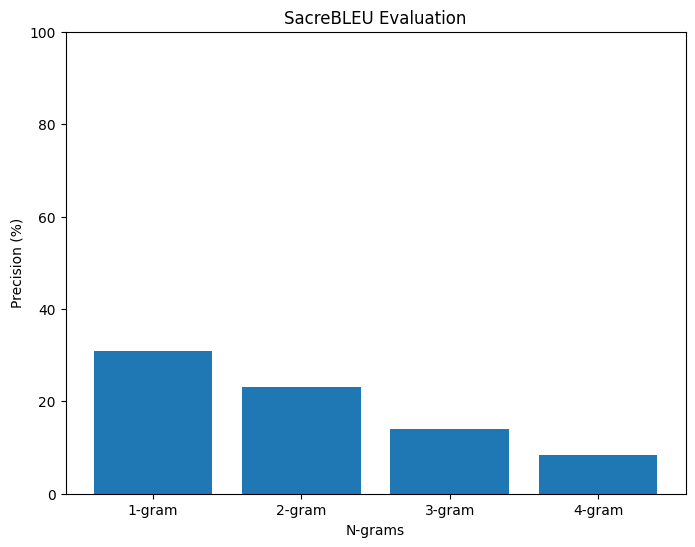

In [6]:
import evaluate as eval
import matplotlib.pyplot as plt

def evaluate_summarization_model(predictions, references):
    metric = eval.load("sacrebleu")
    results = metric.compute(predictions=predictions, references=references)
    return results

def plot_evaluation_results(results):
    # Extract the BLEU score
    bleu_score = results['score']
    bleu_scores = results['precisions']
    ngrams = [f'{i+1}-gram' for i in range(len(bleu_scores))]

    plt.figure(figsize=(10, 6))
    plt.bar(ngrams, bleu_scores, color='blue')
    plt.xlabel('N-grams')
    plt.ylabel('Precision (%)')
    plt.title(f'SacreBLEU Evaluation')
    plt.ylim(0, 100)
    plt.show()

num_samples = 10
samples = test.sample(n=num_samples)

# Chuẩn bị các bản tóm tắt tham chiếu và dự đoán
reference_summaries = [[row["Headline"]] for idx, row in samples.iterrows()]
predicted_summaries = [summarize(row["Short"]) for idx, row in samples.iterrows()]

# Đánh giá hiệu suất của model
results = evaluate_summarization_model(predicted_summaries, reference_summaries)
print(results)

# Vẽ biểu đồ kết quả đánh giá
plot_evaluation_results(results)
